# Neural networks homework assignment

Creater by: *Máté Szakos, Bertalan Lichter*  
Semester: 2025 Spring  
Institution: Budapest University of Technology and Economics

## Short description and the aim of the assigment

Comparison of two signal forecasting approaches over different sampling frequencies $f_s$ and added noise $\epsilon \left(t\right)$:
- One model that recursively forecasts each point (reusing its own forecasts when predicting longer horizons).
- Separate models for each $t \in [𝛥t, t_{max}]$, where $𝛥t = \frac{1}{f_s}$, and $t_{max}$ is the furthest point we want to forecast from our last observation. This approach does not reuse forecasts, thus avoiding the problem of error-accumulation, but forecasting for larger and larger $t$ values becomes an increasingly difficult learning process.

### Dataset

We will construct artificial signals to retain the ability of adjusting the signal's complexity, sampling frequency and noise.

Initial idea for the signal:
$$
\begin{align}
x\left(t\right) &= \sin(a \cdot t + b) \cdot \sin(c \cdot t) + d \cdot t + e \cdot t^2 + \rho\left(t\right) + \epsilon\left(t\right), \\\\
s.t. \:\: \rho\left(t\right) &= \overset{N}{\underset{i=1}{∑}} \nu_i \sin(2\pi \cdot i \cdot f_\text{base} \cdot t + \phi_i), \\
\epsilon\left(t\right) &\sim 𝓝\left(0, σ^2\right)
\end{align}$$

### Models used

We will try out different, quite common model architectures for each use-case and perform hyperparameter-optimization on them to make sure that we compare each model architecture's bests.

### Evaluation

For model comparison, we will use common metrics, for example (but not limited to): R$^2$, MAAPE, NRMSE.

## Downloading and importing dependencies

In [ ]:
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import copy
import itertools
from torch.utils.data import Dataset, DataLoader
from permetrics import RegressionMetric
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import scipy.stats as stats

## Setting up data

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
def generate_pure_signal(a, b, c, t_range):
  return np.sin(a * t_range + b) * np.sin(c * t_range)

In [ ]:
def generate_trend(d, e, t_range):
  return d * t_range + e * t_range ** 2

In [ ]:
def generate_noise(t_range, f_base, sigma, N_noise, phi_array, nu_array):
  assert N_noise == len(phi_array)
  assert N_noise == len(nu_array)

  result = np.zeros_like(t_range)

  for i in range(1, N_noise + 1):
    # phi_i_hat = np.random.normal(phi_array[i - 1], sigma)
    result += nu_array[i - 1] * np.sin(2 * np.pi * i * f_base * t_range + phi_array[i - 1])

  result += np.random.normal(0, sigma ** 2, len(t_range))

  return result

In [ ]:
def generate_noisy_signal(a, b, c, d, e, t_range, f_base, sigma, N_noise, phi_array, nu_array):
  return generate_pure_signal(a, b, c, t_range) + generate_noise(t_range, f_base, sigma, N_noise, phi_array, nu_array) + generate_trend(d, e, t_range)

When setting up the frequencies of both the noises and the signal, I tried to ensure that with any integer $f_s$, it is not exactly periodical; ie. the period time is not divisible by the sampling delta time ($\frac{T_\text{period}}{\Delta t} \notin ℤ$)

In [ ]:
f_s = 2 # Hz
a = .12123123
b = 2.132123
c = 5
d = 0
e = 0
t_observation = 700
f_base = 5
sigma = 0.1
N_noise = 8
nu_array = [
    np.exp(-3)
    for i in range(1, N_noise + 1)
]
phi_array = [
    # np.pi / 2 * i
   # 0.5 * i
    0
    for i in range(1, N_noise + 1)
]

assert len(phi_array) == N_noise
assert len(nu_array) == N_noise

t_range = np.linspace(0, t_observation, f_s * t_observation)
t_max = 40
t_max_pts = int(t_max * f_s)

x_pure = generate_pure_signal(a, b, c, t_range) + generate_trend(d, e, t_range)
x = x_pure + generate_noise(t_range, f_base, sigma, N_noise, phi_array, nu_array)

In [ ]:
snr = 10 * np.log10(np.mean(x_pure ** 2) / np.mean((x_pure - x) ** 2))
print(f"SNR: {snr}dB")

SNR: 13.95065523163037dB


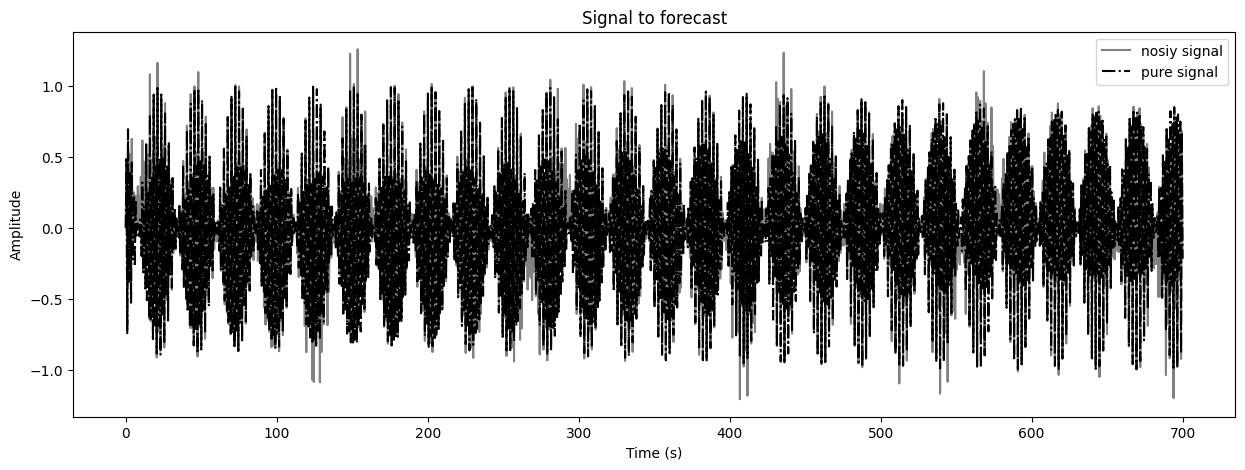

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(t_range, x, color="grey", linestyle="-", label="nosiy signal")
plt.plot(t_range, x_pure, color="black", linestyle="-.", label="pure signal")
plt.title("Signal to forecast")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Creation of datasets

In [ ]:
train_ratio = 0.4
valid_ratio = 0.1
test_ratio = 0.5

assert np.isclose(train_ratio + valid_ratio + test_ratio, 1)

t_train = t_range[:int(len(t_range) * train_ratio)]
t_valid = t_range[int(len(t_range) * train_ratio):int(len(t_range) * (train_ratio + valid_ratio))]
t_test = t_range[int(len(t_range) * (train_ratio + valid_ratio)):]

x_train = x[:int(len(x) * train_ratio)]
x_valid = x[int(len(x) * train_ratio):int(len(x) * (train_ratio + valid_ratio))]
x_test = x[int(len(x) * (train_ratio + valid_ratio)):]

x_train_pure = x_pure[:int(len(x_pure) * train_ratio)]
x_valid_pure = x_pure[int(len(x_pure) * train_ratio):int(len(x_pure) * (train_ratio + valid_ratio))]
x_test_pure = x_pure[int(len(x_pure) * (train_ratio + valid_ratio)):]

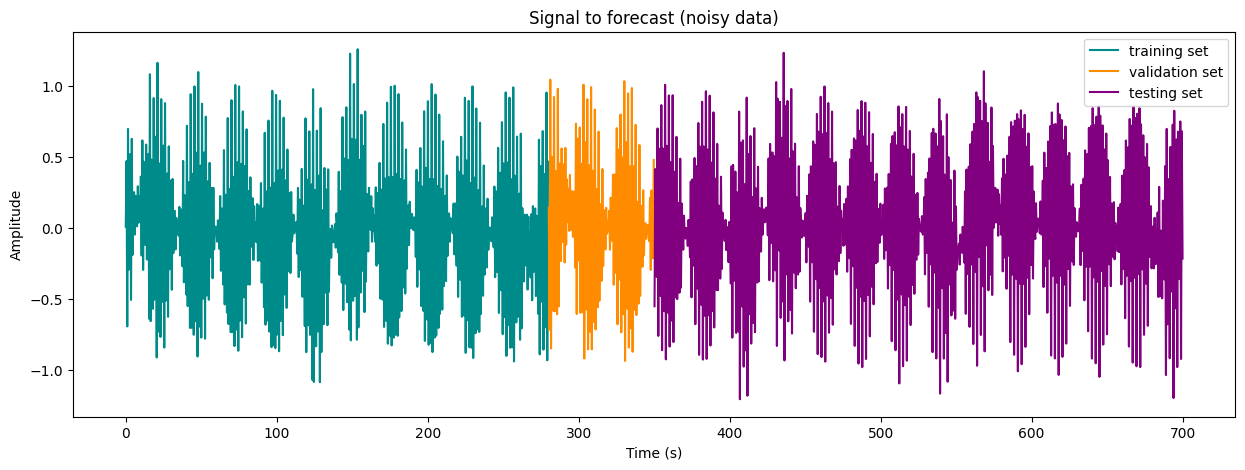

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(t_train, x_train, color="darkcyan", linestyle="-", label="training set")
plt.plot(t_valid, x_valid, color="darkorange", linestyle="-", label="validation set")
plt.plot(t_test, x_test, color="purple", linestyle="-", label="testing set")
plt.title("Signal to forecast (noisy data)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Defining models

In [ ]:

class Conv1DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kernel_size):
        super(Conv1DNN, self).__init__()
        self.conv1 = nn.Conv1d(1, hidden_size, kernel_size)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(hidden_size * (input_size - kernel_size + 1), output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.tanh(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [ ]:
def construct_multistep_model(hyperparams):
  return Conv1DNN(hyperparams["lookback"], hyperparams["fcl_size"], t_max_pts, hyperparams["kernel_size"])

In [ ]:
def construct_single_step_model(hyperparams):
  return Conv1DNN(hyperparams["lookback"], hyperparams["fcl_size"], 1, hyperparams["kernel_size"])

## Defining data loaders

In [ ]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, pure_data, lookback_period, prediction_horizon):
        self.data = data
        self.pure_data = pure_data
        self.lookback_period = lookback_period
        self.prediction_horizon = prediction_horizon

    def __len__(self):
        return len(self.data) - self.lookback_period - self.prediction_horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback_period]
        y = self.data[idx + self.lookback_period:idx + self.lookback_period + self.prediction_horizon]
        y_pure = self.pure_data[idx + self.lookback_period:idx + self.lookback_period + self.prediction_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_pure, dtype=torch.float32)

In [ ]:
def construct_datasets(lookback, prediction_horizon):
  # we use the noisy dataset for training and validation, but provide the testing set the pure signal (for better accuracy measures)
  train_dataset = TimeSeriesDataset(x_train, x_train, lookback, prediction_horizon)
  valid_dataset = TimeSeriesDataset(x_valid, x_valid, lookback, prediction_horizon)
  test_dataset = TimeSeriesDataset(x_test, x_test_pure, lookback, prediction_horizon)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  return train_loader, valid_loader, test_loader

## Defining training loops

### Multistep

In [ ]:
def train_multistep_model(model, train_dataloader, valid_dataloader, hyperparams):

  optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
  loss_fn = torch.nn.MSELoss()

  model.train()

  best_val_loss = float('inf')
  early_stopping_counter = 0
  patience = 10
  best_model_state = copy.deepcopy(model.state_dict())

  for epoch in tqdm(range(hyperparams["epochs"]), colour="blue", desc="Training multistep...", unit="epoch"):

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()


    # Evaluate on validation set
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
      for x, y in valid_dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        total_valid_loss += loss.item()
    model.train()

    avg_valid_loss = total_valid_loss / len(valid_dataloader)

    # Implement early stopping
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        early_stopping_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break


  model.load_state_dict(best_model_state)
  return model


In [ ]:
def evaluate_multistep(hyperparams):
  model = construct_multistep_model(hyperparams)

  train_loader, valid_loader, test_loader = construct_datasets(hyperparams["lookback"], t_max_pts)

  model = train_multistep_model(model, train_loader, valid_loader, hyperparams)

  metrics = np.empty((0, t_max_pts - 2, 3))

  predictions = np.empty((0, t_max_pts + 1))
  true_values = np.empty((0, t_max_pts + 1))

  for i, (x, y) in enumerate(tqdm(test_loader)):
    y_preds = model(x).detach().numpy()
    y_true = y.detach().numpy()

    last_values = np.expand_dims(x.detach().numpy()[:, -1], 0).T

    y_preds = np.concatenate((last_values, y_preds), axis=1)
    y_true = np.concatenate((last_values, y_true), axis=1)

    for p, t in zip(y_preds, y_true):

      metrics_for_series = np.empty((t_max_pts - 2, 3))

      for horizon in range(2, t_max_pts):
        metric = RegressionMetric(p[:horizon], t[:horizon])

        metrics_for_series[horizon - 2, :] = np.array([
            metric.R2(),
            metric.mean_arctangent_absolute_percentage_error(),
            metric.normalized_root_mean_square_error()
        ])

      metrics = np.concatenate((metrics, np.expand_dims(metrics_for_series, 0)), axis=0)

    predictions = np.concatenate((predictions, y_preds), axis=0)
    true_values = np.concatenate((true_values, y_true), axis=0)

  return pd.DataFrame(metrics[:, -1, :], columns=["R2", "MAAPE", "NRMSE"]), predictions, true_values, metrics




### Single step

In [ ]:
def train_single_step(model, train_loader, valid_loader, hyperparams):

  optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
  loss_fn = torch.nn.MSELoss()

  model.train()

  best_val_loss = float('inf')
  early_stopping_counter = 0
  patience = 10
  best_model_state = copy.deepcopy(model.state_dict())

  for epoch in tqdm(range(hyperparams["epochs"]), colour="red", desc=f"Training single-step...", unit="epoch"):
    for x, y in train_loader:
      optimizer.zero_grad()
      y_pred = model(x)[:, 0]
      loss = loss_fn(y_pred, y[:, 0])
      loss.backward()
      optimizer.step()

    # Evaluate on validation set
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
      for x, y in valid_loader:
        y_pred = model(x)[:, 0]
        loss = loss_fn(y_pred, y[:, 0])
        total_valid_loss += loss.item()
    model.train()

    avg_valid_loss = total_valid_loss / len(valid_loader)

    # Implement early stopping
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        early_stopping_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
  model.load_state_dict(best_model_state)
  return model

In [ ]:
def evaluate_single_step(hyperparams):
  model = construct_single_step_model(hyperparams)

  train_loader, valid_loader, test_loader = construct_datasets(hyperparams["lookback"], t_max_pts)

  model = train_single_step(model, train_loader, valid_loader, hyperparams)

  num_test_points = len(test_loader)

  metrics = np.empty((0, t_max_pts - 2, 3))

  predictions = np.empty((0, t_max_pts + 1))
  true_values = np.empty((0, t_max_pts + 1))

  for i, (x, y) in enumerate(tqdm(test_loader)):
    y_preds = np.empty((y.shape[0], t_max_pts))
    y_true = y.detach().numpy()

    for t in range(t_max_pts):
      input = np.concatenate((x.detach().numpy(), y_preds[:, :t]), axis=1) if t > 0 else x.detach().numpy()
      input = input[:, -hyperparams["lookback"]:]
      y_preds[:, t] = model(torch.tensor(input, dtype=torch.float)).detach().numpy()[:, 0]

    last_value = np.expand_dims(x.detach().numpy()[:, -1], 0).T

    y_preds = np.concatenate((last_value, y_preds), axis=1)
    y_true = np.concatenate((last_value, y_true), axis=1)

    predictions = np.concatenate((predictions, y_preds), axis=0)
    true_values = np.concatenate((true_values, y_true), axis=0)

    for p, t in zip(y_preds, y_true):

      metrics_for_series = np.empty((t_max_pts - 2, 3))

      for horizon in range(2, t_max_pts):
        metric = RegressionMetric(p[:horizon], t[:horizon])

        metrics_for_series[horizon - 2, :] = np.array([
            metric.R2(),
            metric.mean_arctangent_absolute_percentage_error(),
            metric.normalized_root_mean_square_error()
        ])

      metrics = np.concatenate((metrics, np.expand_dims(metrics_for_series, 0)), axis=0)


  return pd.DataFrame(metrics[:, -1, :], columns=["R2", "MAAPE", "NRMSE"]), predictions, true_values, metrics




## Train and evaluate models

### Evaluating multistep model

In [ ]:
import itertools

# Define hyperparameter grids
lookback_values = [40, 50, 60]
epoch_values = [60, 70, 80]
learning_rates = [1e-3, 1e-4]
kernel_sizes = [3, 5, 7, 9]
fcl_sizes = [8,16, 32, 64, 128]

# Track the best result
best_nrmse = float("inf")
best_params = None
best_metrics_df = None
best_preds = None
best_targets = None
best_metrics = None

# Create full grid of combinations
combinations = list(itertools.product(
    lookback_values,
    epoch_values,
    learning_rates,
    kernel_sizes,
    fcl_sizes
))

# Loop through all hyperparameter combinations
for lookback, epochs, lr, ksize, fcl in combinations:
    hyperparams = {
        "lookback": lookback,
        "epochs": epochs,
        "learning_rate": lr,
        "kernel_size": ksize,
        "fcl_size": fcl
    }

    try:
        # print(f"Evaluating: {hyperparams}")
        metrics_df, preds, targets, metrics = evaluate_multistep(hyperparams)

        current_nrmse = metrics_df["NRMSE"].mean()
        # print(f"NRMSE: {current_nrmse}")

        if current_nrmse < best_nrmse:
            best_nrmse = current_nrmse
            best_params = hyperparams
            best_metrics_df = metrics_df
            best_preds = preds
            best_targets = targets
            best_metrics = metrics
            print(f"New best model found with NRSME = {best_nrmse}")

    except Exception as e:
        print(f"Error with hyperparams {hyperparams}: {e}")

print(f"\nBest hyperparameters: {best_params}")
print(f"Best NRSME: {best_nrmse}")



Error with hyperparams {'lookback': 40, 'epochs': 60, 'learning_rate': 0.001, 'kernel_size': 3, 'fcl_size': 8}: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)
Error with hyperparams {'lookback': 40, 'epochs': 60, 'learning_rate': 0.001, 'kernel_size': 3, 'fcl_size': 16}: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)
Error with hyperparams {'lookback': 40, 'epochs': 60, 'learning_rate': 0.001, 'kernel_size': 3, 'fcl_size': 32}: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)
Error with hyperparams {'lookback': 40, 'epochs': 60, 'learning_rate': 0.001, 'kernel_size': 3, 'fcl_size': 64}: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)
Error with hyperparams {'lookback': 40, 'epochs': 60, 'learning_rate': 0.001,

Best hyperparameters: {'lookback': 60, 'epochs': 60, 'learning_rate': 0.0001, 'kernel_size': 5, 'fcl_size': 8}


In [ ]:
multistep_metrics_df, multistep_preds, multistep_targets, multistep_metrics = evaluate_multistep({'lookback': 60, 'epochs': 60, 'learning_rate': 0.0001, 'kernel_size': 5, 'fcl_size': 8})

100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


In [ ]:
multistep_metrics_df.describe()

,R2,MAAPE,NRMSE
count,561.000000,561.000000,561.000000
mean,0.996943,0.141795,0.052993
std,0.001832,0.038001,0.015380
min,0.990254,0.063674,0.029800
25%,0.995883,0.114157,0.040606
50%,0.997641,0.136857,0.048513
75%,0.998355,0.166824,0.064159
max,0.999107,0.258390,0.097862


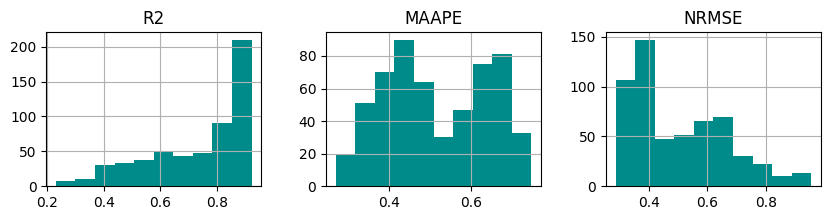

In [ ]:
multistep_metrics_df.hist(figsize=(10, 2), layout=(1, 3), color="darkcyan")
plt.show()

### Evaluating single step models

In [ ]:
import itertools

# Define hyperparameter grids
lookback_values = [40, 50, 60]
epoch_values = [60, 70, 80]
learning_rates = [1e-3, 1e-4]
kernel_sizes = [3, 5, 7, 9]
fcl_sizes = [8,16, 32, 64, 128]

# Track the best result
best_nrmse = float("inf")
best_params = None
best_metrics_df = None
best_preds = None
best_targets = None
best_metrics = None

# Create full grid of combinations
combinations = list(itertools.product(
    lookback_values,
    epoch_values,
    learning_rates,
    kernel_sizes,
    fcl_sizes
))

# Loop through all hyperparameter combinations
for lookback, epochs, lr, ksize, fcl in combinations:
    hyperparams = {
        "lookback": lookback,
        "epochs": epochs,
        "learning_rate": lr,
        "kernel_size": ksize,
        "fcl_size": fcl
    }

    try:
        # print(f"Evaluating: {hyperparams}")
        metrics_df, preds, targets, metrics = evaluate_single_step(hyperparams)

        current_nrmse = metrics_df["NRMSE"].mean()
        # print(f"NRMSE: {current_nrmse}")

        if current_nrmse < best_nrmse:
            best_nrmse = current_nrmse
            best_params = hyperparams
            best_metrics_df = metrics_df
            best_preds = preds
            best_targets = targets
            best_metrics = metrics
            print(f"New best model found with NRSME = {best_nrmse}")

    except Exception as e:
        print(f"Error with hyperparams {hyperparams}: {e}")

print(f"\nBest hyperparameters: {best_params}")
print(f"Best NRSME: {best_nrmse}")



  0%|          | 0/19 [00:00<?, ?it/s]


KeyboardInterrupt: 

Best hyperparameters: {'lookback': 60, 'epochs': 70, 'learning_rate': 0.001, 'kernel_size': 7, 'fcl_size': 16}


In [ ]:
single_step_metrics_df, single_step_preds, single_step_targets, single_step_metrics = evaluate_single_step({'lookback': 60, 'epochs': 70, 'learning_rate': 0.001, 'kernel_size': 7, 'fcl_size': 16})

Training single-step...:  31%|███▏      | 22/70 [00:00<00:01, 28.67epoch/s]


Early stopping triggered after 23 epochs.


100%|██████████| 18/18 [00:06<00:00,  2.59it/s]


In [ ]:
single_step_metrics_df.describe()

,R2,MAAPE,NRMSE
count,561.000000,561.000000,561.000000
mean,0.983068,0.268878,0.124674
std,0.008837,0.045244,0.031973
min,0.955019,0.180249,0.080115
25%,0.977305,0.238641,0.098538
50%,0.985808,0.258839,0.116803
75%,0.990101,0.296830,0.149235
max,0.993446,0.417857,0.211316


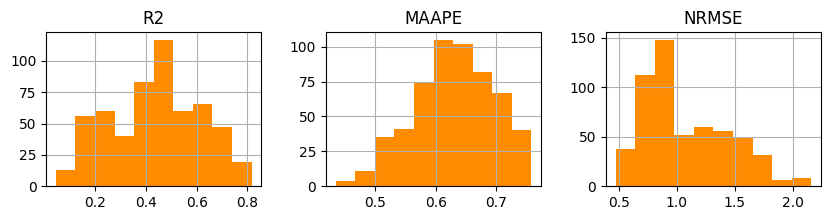

In [ ]:
single_step_metrics_df.hist(figsize=(10, 2), layout=(1, 3), color="darkorange")
plt.show()

### Contrasing results

#### Distributions of accuracy measures

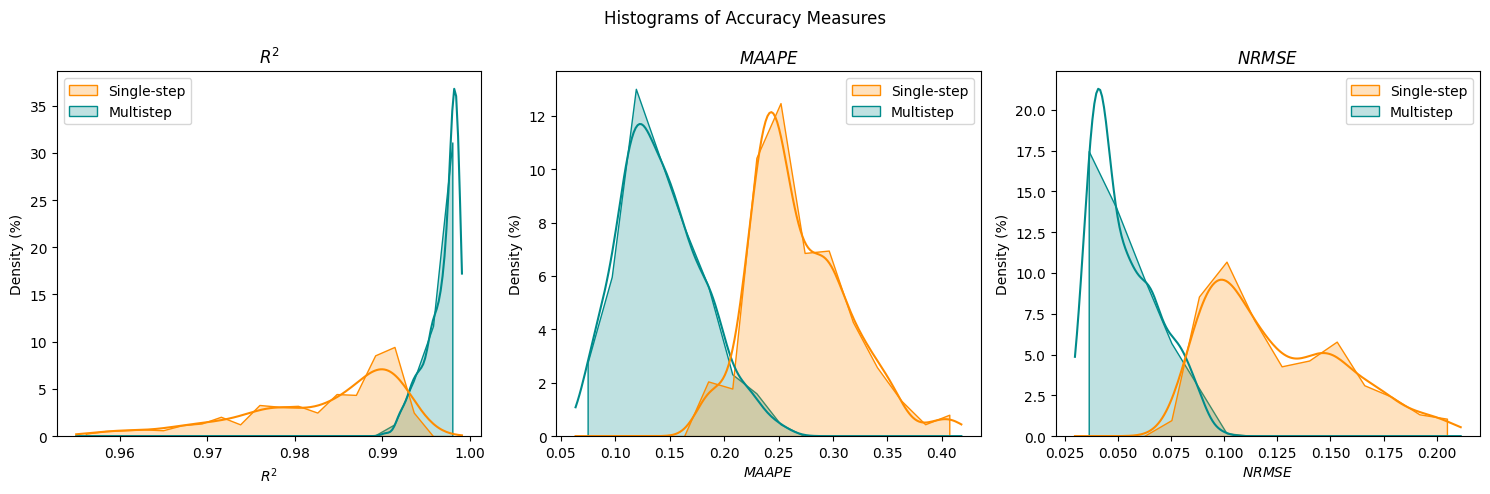

In [ ]:

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3).ravel()

accuracy_measures = ["R2", "MAAPE", "NRMSE"]
accuracy_measure_names = ["$R^2$", "$MAAPE$", "$NRMSE$"]

for i, (measure, measure_name) in enumerate(zip(accuracy_measures, accuracy_measure_names)):
  sns.histplot(pd.DataFrame({
                 "Single-step": single_step_metrics_df[measure],
                 "Multistep": multistep_metrics_df[measure]
               }),
               kde=True,
               palette=["darkorange", "darkcyan"],
               ax=axs[i],
               stat="percent",
               element="poly"
               )
  axs[i].set_title(measure_name)
  axs[i].set_xlabel(measure_name)
  axs[i].set_ylabel("Density (%)")

plt.suptitle("Histograms of Accuracy Measures")
plt.tight_layout()
plt.savefig("histograms.svg")
plt.show()


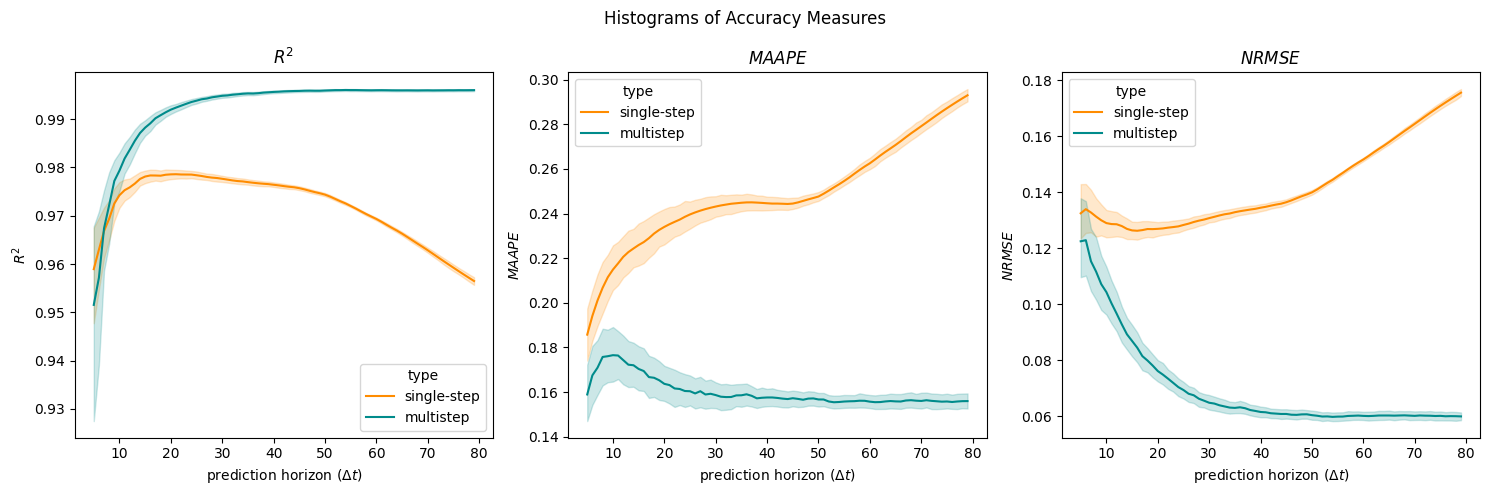

In [ ]:
fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3).ravel()

accuracy_measures = ["R2", "MAAPE", "NRMSE"]
accuracy_measure_names = ["$R^2$", "$MAAPE$", "$NRMSE$"]

# early measurements can be misleadingly off the mark and thus the plots will be squeezed up
cutoff_horizon = 5 # in delta time

for i, (measure, measure_name) in enumerate(zip(accuracy_measures, accuracy_measure_names)):
  plot_df = pd.DataFrame({
                 "horizon": list(range(2, t_max_pts)) * (single_step_metrics.shape[0] + multistep_metrics.shape[0]),
                 measure: np.concatenate((single_step_metrics[:, :, i].flatten(), multistep_metrics[:, :, i].flatten())),
                 "type": np.concatenate((np.repeat("single-step", single_step_metrics.shape[1] * single_step_metrics.shape[0]), np.repeat("multistep", multistep_metrics.shape[1] * multistep_metrics.shape[0])))
               })

  if cutoff_horizon is not None:
    plot_df = plot_df[plot_df["horizon"] >= cutoff_horizon]

  sns.lineplot(plot_df,
               x="horizon",
               y=measure,
               hue="type",
               palette=["darkorange", "darkcyan"],
               ax=axs[i],
               errorbar=("ci", 95)
               )
  axs[i].set_title(measure_name)
  axs[i].set_xlabel(r"prediction horizon ($\Delta t$)")
  axs[i].set_ylabel(measure_name)

plt.suptitle("Histograms of Accuracy Measures")
plt.tight_layout()
plt.savefig("metrics_over_horizon.svg")
plt.show()


In [ ]:
def are_datasets_statistically_significant(data1, data2, alpha = 0.05):
  statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')

  return p_value <= alpha

These are based on the total prediction horizon (the last entries in the metrics tensors)

In [ ]:
for measure in accuracy_measures:
  print(f"{measure} is statistically significant: {are_datasets_statistically_significant(single_step_metrics_df[measure], multistep_metrics_df[measure])}")

R2 is statistically significant: True
MAAPE is statistically significant: True
NRMSE is statistically significant: True


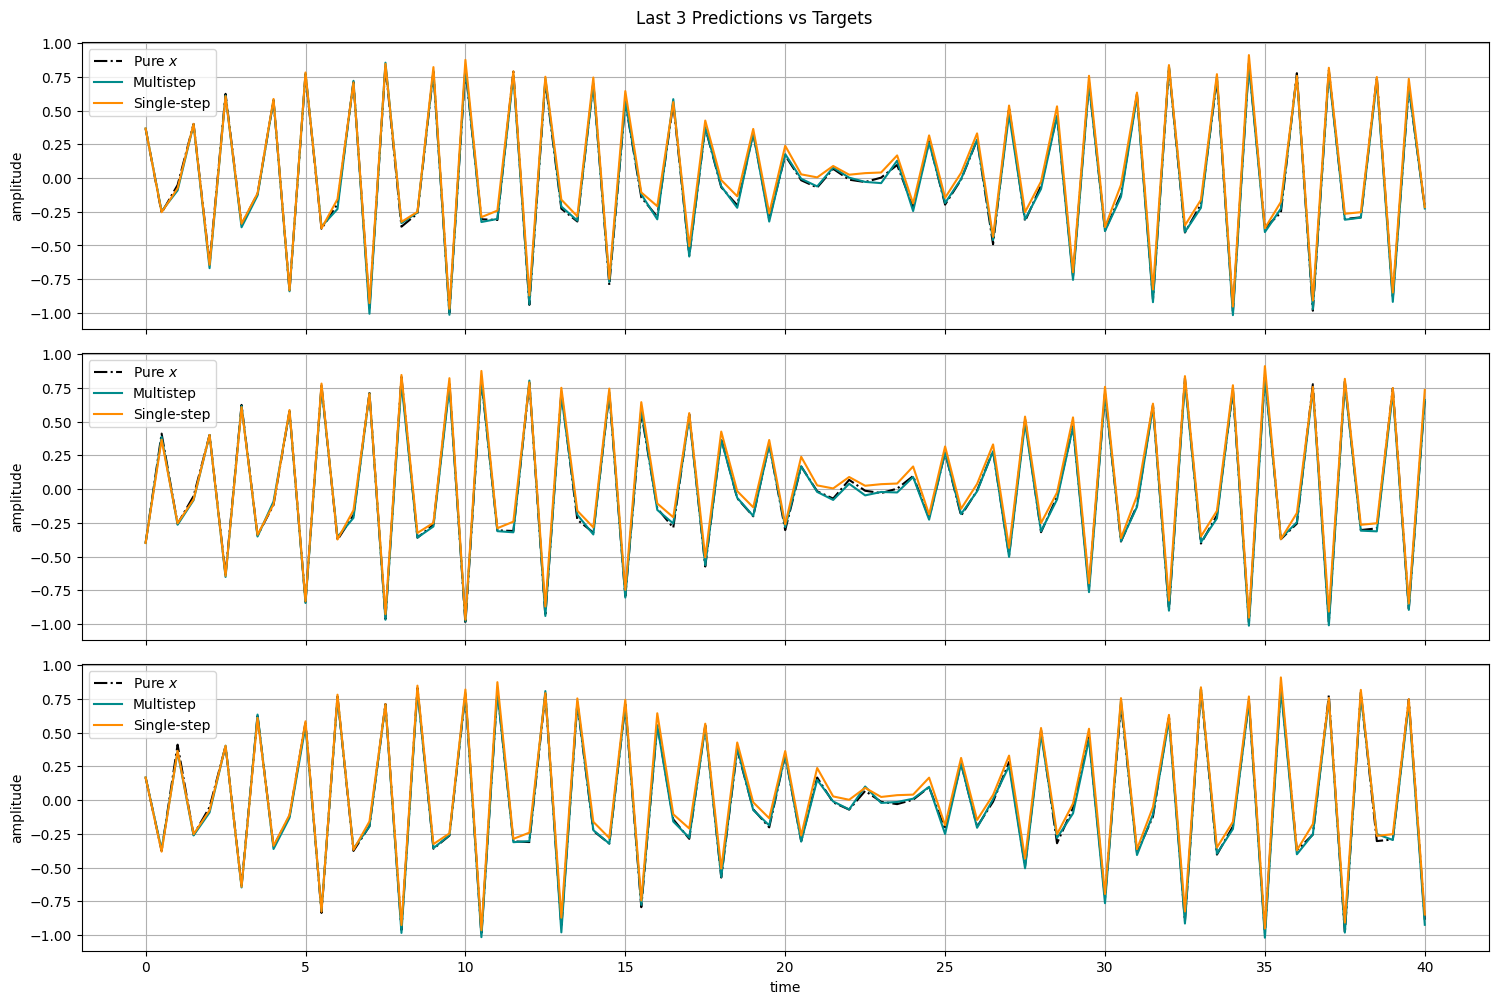

In [ ]:
# prompt: display the first N number of predictions and targets (where the targets are the same). plot them

number_of_plots = 3 #@param {type:"integer"}

# Assuming multistep_preds and multistep_targets are already defined from previous code
# and they have the same shape

fig = plt.figure(figsize=(15, 1 + number_of_plots * 3))
axs = fig.subplots(
    number_of_plots,
    1,
    sharex=True,
    sharey=True,
)

try:
  axs[0]
except:
  axs = [axs]

for i in range(1, min(len(multistep_preds), len(single_step_preds), number_of_plots + 1)):
  t_plot = np.arange(0, t_max_pts + 1) / f_s
  axs[i - 1].plot(t_plot, multistep_targets[-i], label=f'Pure $x$', color="black", linestyle="-.")
  axs[i - 1].plot(t_plot, multistep_preds[-i], label=f'Multistep', color="darkcyan")
  axs[i - 1].plot(t_plot, single_step_preds[-i], label=f'Single-step', color="darkorange")
  axs[i - 1].set_ylabel("amplitude")
  axs[i - 1].legend()
  axs[i - 1].grid()

plt.suptitle(f"Last {min(number_of_plots, len(multistep_preds))} Predictions vs Targets")
plt.tight_layout()
plt.xlabel("time")
plt.savefig("predictions_vs_targets.svg")
plt.show()
